In [12]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('calendar.csv', 'calendar'),
    ('customer_flight_activity.csv', 'customer_flight_activity'),
    ('customer_loyalty_history.csv', 'customer_loyalty_history')
    # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='divi96',
    database='airlines'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = r'C:\Users\ASUS\Documents\Python\Airline Loyalty'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '').replace('-', '').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'{col} {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS {table_name} ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO {table_name} ({', '.join(['' + col + '' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing calendar.csv
NaN values before replacement:
Date                0
Start_of_Year       0
Start_of_Quarter    0
Start_of_Month      0
dtype: int64

Processing customer_flight_activity.csv
NaN values before replacement:
Loyalty_Number                 0
Year                           0
Month                          0
Total_Flights                  0
Distance                       0
Points_Accumulated             0
Points_Redeemed                0
Dollar_Cost_Points_Redeemed    0
Revenue                        0
dtype: int64

Processing customer_loyalty_history.csv
NaN values before replacement:
Loyalty_Number            0
Country                   0
Province                  0
City                      0
Postal_Code               0
Gender                    0
Education                 0
Salary                 4238
Marital_Status            0
Loyalty_Card              0
CLV                       0
Enrollment_Type           0
Enrollment_Year           0
Enrollment_Month          

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
db  =  mysql.connector.connect(host = 'localhost',
                             username = 'root',
                             password = 'divi96',
                             database = "airlines")
cur = db.cursor()

In [7]:
df.dropna(inplace = True)

In [8]:
df.head()

,Loyalty_Number,Country,Province,City,Postal_Code,Gender,Education,Salary,Marital_Status,Loyalty_Card,CLV,Enrollment_Type,Enrollment_Year,Enrollment_Month,Cancellation_Year,Cancellation_Month
31,201574,Canada,Ontario,Ottawa,K1F 2R2,Female,Bachelor,51375.0,Married,Star,3893.31,Standard,2015,4,2015.0,12.0
39,834891,Canada,British Columbia,Vancouver,V5R 1W3,Female,Bachelor,54460.0,Married,Star,3911.12,Standard,2017,3,2017.0,4.0
45,733338,Canada,Ontario,Thunder Bay,K8T 5M5,Female,Bachelor,80697.0,Married,Star,3919.37,Standard,2016,6,2017.0,2.0
51,869743,Canada,Ontario,Sudbury,M5V 1G5,Female,Bachelor,73236.0,Single,Star,3924.42,Standard,2016,11,2017.0,7.0
65,386082,Canada,Alberta,Edmonton,T9G 1W3,Female,Bachelor,30486.0,Divorced,Aurora,5391.97,2018 Promotion,2018,3,2018.0,11.0


In [11]:
df.isnull().sum()

Loyalty_Number        0
Country               0
Province              0
City                  0
Postal_Code           0
Gender                0
Education             0
Salary                0
Marital_Status        0
Loyalty_Card          0
CLV                   0
Enrollment_Type       0
Enrollment_Year       0
Enrollment_Month      0
Cancellation_Year     0
Cancellation_Month    0
dtype: int64

# 1. Total Number of Unique Customers are in the dataset?

In [3]:
query = """select count(distinct loyalty_number) as unique_customer_count,count(distinct province) as unique_province_count,
count(distinct city) as unique_city_count from customer_loyalty_history;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Customer_Count","Province_Count","City_Count"])
df

,Customer_Count,Province_Count,City_Count
0,16737,11,29


# 2. Average revenue per customer?

In [4]:
query = """ select round(avg(revenue),2) from customer_flight_activity"""
cur.execute(query)
data = cur.fetchall()
"Average revenue per customer is :",data[0][0]

('Average revenue per customer is :', 232.97)

# 3. Total Number of Flights Taken

In [7]:
query = """select sum(Total_Flights) from customer_flight_activity"""
cur.execute(query)
data = cur.fetchall()
"Total Flights Taken by Customers:",data[0][0]

('Total Flights Taken by Customers:', Decimal('1017616'))

# 4. Calculating the Average Number of Flights taken by Each Customers

In [6]:
query = """select round(avg(Total_Flights),2) from customer_flight_activity"""
cur.execute(query)
data = cur.fetchall()
"Average Number Of Flights Taken by  Each Customers:",data[0][0]

('Average Number Of Flights Taken by  Each Customers:', Decimal('1.29'))

# 5. Identifying the distribution of customers across different loyalty tiers?

In [9]:
query = """ select loyalty_card,count(distinct loyalty_number) as num_of_customers from customer_loyalty_history 
group by loyalty_card order by num_of_customers desc """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ['Loyalty Card','Distribution of Customers'])
df

,Loyalty Card,Distribution of Customers
0,Star,7637
1,Nova,5671
2,Aurora,3429


# 6. Calculating the average number of flights per customer per year?

In [11]:
query = """ select distinct loyalty_number,year,avg(Total_Flights) as Avg_Num_of_flights from customer_flight_activity 
group by loyalty_number,year order by Avg_Num_of_flights desc """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Loyalty Number","Year","Total FLights"])
df

,Loyalty Number,Year,Total FLights
0,813455,2018,9.4545
1,385092,2018,9.2727
2,983416,2018,9.0909
3,110065,2018,8.8182
4,625320,2018,8.7273
...,...,...,...
32498,250089,2018,0.0000
32499,252135,2018,0.0000
32500,252472,2018,0.0000
32501,264034,2018,0.0000


# 7.Top 10 Customers with the highest number of flights

In [23]:
query = """ select loyalty_number,sum(total_flights) as Total_Flights from customer_flight_activity 
group by loyalty_number order by Total_Flights desc limit 10 """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Customer Loyalty Number","Total Flights Taken"])
df

,Customer Loyalty Number,Total Flights Taken
0,336882,212
1,813455,208
2,385092,204
3,983416,200
4,732304,196
5,110065,194
6,464187,192
7,625320,192
8,556492,190
9,255836,188


# 8. Plotting the month/season which has the highest customer flight activity?

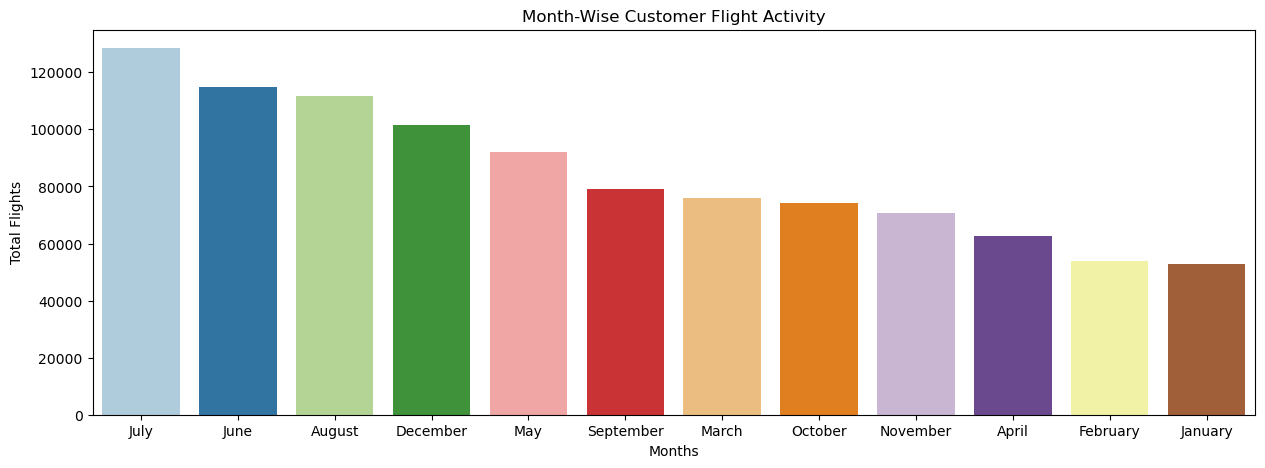

In [14]:
query = """ select case month when 1 then 'January' when 2 then 'February' when 3 then 'March' when 4 then 'April'
when 5 then 'May'
when 6 then 'June'
when 7 then 'July'
when 8 then 'August'
when 9 then 'September'
when 10 then 'October'
when 11 then 'November'
when 12 then 'December'
end as month_name,sum(total_flights) as Total_Flights from customer_flight_activity 
group by month,month_name order by Total_Flights desc """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Months","Total Flights"])
plt.figure(figsize = (15,5))
sns.barplot(x = "Months" , y = "Total Flights",data = df,hue = "Months",palette = "Paired")
plt.title("Month-Wise Customer Flight Activity")
plt.show()

## From the graph, we can see that July has the highest customer flight activity, followed by June, August, and September.

# 9. Top 10 Revenue generating Customers

In [15]:
query = """ select loyalty_number,sum(revenue) as Total_Revenue from customer_flight_activity group by loyalty_number 
order by Total_Revenue desc limit 10"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Customer Loyalty Number","Total Revenue"])
df

,Customer Loyalty Number,Total Revenue
0,689839,42925.92
1,893866,40473.60
2,500248,38099.28
3,775768,37735.44
4,133324,37410.48
5,471015,37148.16
6,385092,37029.12
7,201273,36055.44
8,208961,36045.12
9,556492,35947.68


# 10. Calculating Revenue per Loyalty Tier

In [17]:
query = """ select l.loyalty_card,round(sum(f.revenue),2) as Total_Revenue,round(sum(f.revenue)/(select sum(revenue) from customer_flight_activity)*100,2) as Rvenue_Percentage 
from customer_loyalty_history as l join customer_flight_activity as f 
on l.loyalty_number = f.loyalty_number group by loyalty_card order by Total_Revenue desc """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Loyalty_card","Total Revenue","Revenue_Percentage"])
df

,Loyalty_card,Total Revenue,Revenue_Percentage
0,Star,1.655205e+08,90.41
1,Nova,1.245686e+08,68.04
2,Aurora,7.608460e+07,41.56


# 11.Identifying do higher-tier customers take more flights than lower-tier ones?

In [19]:
query = """ SELECT l.loyalty_card,round(AVG(f.total_flights),2) AS avg_flights_per_customer FROM customer_loyalty_history l
JOIN customer_flight_activity f ON l.loyalty_number = f.loyalty_number
GROUP BY l.loyalty_card
ORDER BY avg_flights_per_customer DESC """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Loyalty_card","Average_Flights_Per_Customer"])
df

,Loyalty_card,Average_Flights_Per_Customer
0,Nova,1.30
1,Star,1.29
2,Aurora,1.29


# 12. Revenue Contribution by Tier Over Time

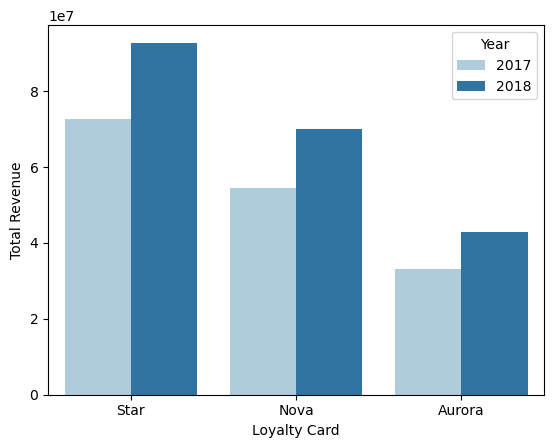

In [15]:
# Calculating Revenue Contribution by Tier Over Time
query = """ select f.year,l.loyalty_card,round(sum(f.revenue),2) as Total_Revenue 
from customer_loyalty_history as l join customer_flight_activity as f 
on l.loyalty_number = f.loyalty_number group by f.year,l.loyalty_card order by Total_Revenue desc """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Year","Loyalty Card","Total Revenue"])
sns.barplot(x = "Loyalty Card",y = "Total Revenue",data = df,hue = "Year",palette = "Paired")
plt.show()

## From the above graph we can see that Star members generated the highest revenue, and 2018 outperformed 2017.

# 13. Is there Customers who were active before but stopped flying in recent years.

In [21]:
query = """ with a as (select loyalty_number,min(year) as first_year,max(year) as last_year from customer_flight_activity 
group by loyalty_number)
select loyalty_number,first_year,last_year from a where last_year< (select max(year) from customer_flight_activity)"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Loyalty Number","First Year","Last Year"])
df

,Loyalty Number,First Year,Last Year


## All customers in the dataset remained active during the observation period

# 14. Identifying Which loyalty tier has the highest cancellation rate?

In [22]:
query = """ select loyalty_card,count(case when cancellation_year is not null then 1 end) * 100/count(*) as cancellation_rate 
from customer_loyalty_history group by loyalty_card order by cancellation_rate desc """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Loyalty Card","Cancellation Percentage"])
df

,Loyalty Card,Cancellation Percentage
0,Aurora,56.5471
1,Nova,56.3216
2,Star,55.8989


# 15. Identifying is there a relationship between points redeemed and cancellations?

In [18]:

query = """select case when l.cancellation_year is not null then 'Cancelled' else 'Active' end as Status,
count(distinct l.loyalty_number) as num_customers,round(avg(f.points_redeemed),0) as avg_points_redeemed_per_customer,
sum(f.points_redeemed) as Points_Redeemed 
from customer_flight_activity as f join customer_loyalty_history as l 
on l.loyalty_number = f.loyalty_number group by Status;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Customer Loyalty Tier Status","Number Of Customers","Average Points Redeemed","Total Points Redeemed"])
df

,Customer Loyalty Tier Status,Number Of Customers,Average Points Redeemed,Total Points Redeemed
0,Active,14670,34,23701842
1,Cancelled,16737,29,25500446


## Cancelled customers redeemed more total points (25.5M) than active customers (23.7M), despite lower average redemption.